<a href="https://colab.research.google.com/github/Linsonng/From-StableDiffusion-to-Computer-Generated-Holograph/blob/main/%E2%80%9CStableDiffusion2CGH-V1%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title #Diffuser setup
#@markdown Setup cells need to be run only once.

# accessment
import os
%cd /content/
if not os.path.isdir('/content/drive'):
  from google.colab import drive
  drive.mount('/content/drive')


# packages
%pip install torch==2.0.1
%pip install diffusers transformers accelerate mediapy triton scipy ftfy spacy==3.5.0
%pip install xformers==0.0.16rc425
%pip install timm
%pip install odak


# imports
from google.colab import output as command_output
import warnings
import numpy as np
import cv2
import torch
import urllib.request
import matplotlib.pyplot as plt
from PIL import Image
import sys
import argparse
import odak
from tqdm import tqdm
import mediapy as media
from diffusers import StableDiffusionPipeline
import random


# settings
model_id = "dreamlike-art/dreamlike-photoreal-2.0"
# warnings.filterwarnings('ignore')
scheduler = None
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

# functions
def create_dirs(paths):
  for path in paths:
    if not os.path.isdir(path) and path != '':
      !mkdir "{path}"
def basename(path):
  filename = os.path.basename(path).strip()#.replace(" ", "_")
  filebase = os.path.splitext(filename)[0]
  return filebase
def path_ext(path, only_ext=False):
  filename, extension = os.path.splitext(path)
  if only_ext == True:
    extension = extension[1:]
  return extension
class c:
  title = '\033[96m'
  ok = '\033[92m'
  okb = '\033[94m'
  warn = '\033[93m'
  fail = '\033[31m'
  endc = '\033[0m'
  bold = '\033[1m'
  dark = '\33[90m'
  u = '\033[4m'

def op(typex, msg, value='', time=False):
  if time == True:
    stamp = timestamp(human_readable=True)
    typex = c.dark+stamp+' '+typex
  if value != '':
    print(typex+msg+c.endc, end=' ')
    print(value)
  else:
    print(typex+msg+c.endc)

def cgh(colabSettings):
    # settings_filename='/content/mydrive/test/ColabSetting.txt'

    # parser = argparse.ArgumentParser(description=__title__)
    # parser.add_argument(
    #                     '--settings',
    #                     type=argparse.FileType('r'),
    #                     help='Filename for the settings file. Default is {}'.format(settings_filename)
    #                    )
    # parser.add_argument(
    #                     '--color',
    #                     type=int,
    #                     help='Color channel. Default is as described by the settings file.'
    #                    )
    # # args = parser.parse_args()
    # args, unknown = parser.parse_known_args()
    # print("found unknown args: ", unknown)
    # if type(args.settings) != type(None):
    #     settings_filename = str(args.settings.name)

    # if type(args.color) != type(None):
    #     settings["target"]["color channel"] = args.colour
    settings = colabSettings
    odak.tools.check_directory(settings["general"]["output directory"])
    ch = settings["target"]["color channel"]
    target_image = odak.learn.tools.load_image(settings["target"]["image filename"], normalizeby = 255.)[: , :, ch]
    target_depth = 1. - odak.learn.tools.load_image(settings["target"]["depth filename"], normalizeby = 255.)
    if len(target_depth.shape) > 2:
        target_depth = target_depth[:, :, 1]
    device = torch.device(settings["general"]["device"])
    loss_function = odak.learn.wave.multiplane_loss(
                                                    target_image = target_image.unsqueeze(0),
                                                    target_depth = target_depth,
                                                    target_blur_size = settings["target"]["defocus blur size"],
                                                    number_of_planes = settings["target"]["number of planes"],
                                                    multiplier = settings["target"]["multiplier"],
                                                    blur_ratio = settings["target"]["blur ratio"],
                                                    weights = settings["target"]["weights"],
                                                    scheme = settings["target"]["scheme"],
                                                    device = device
                                                   )
    targets, focus_target, depth = loss_function.get_targets()
    for hologram_id in range(settings["general"]["hologram number"]):
        optimizer = odak.learn.wave.multiplane_hologram_optimizer(
                                                                  wavelength = settings["beam"]["wavelength"],
                                                                  image_location = settings["image"]["location"],
                                                                  image_spacing = settings["image"]["delta"],
                                                                  slm_pixel_pitch = settings["slm"]["pixel pitch"],
                                                                  slm_resolution = settings["slm"]["resolution"],
                                                                  targets = targets,
                                                                  propagation_type = settings["general"]["propagation type"],
                                                                  number_of_iterations = settings["general"]["iterations"],
                                                                  learning_rate = settings["general"]["learning rate"],
                                                                  number_of_planes = settings["target"]["number of planes"],
                                                                  mask_limits = settings["target"]["mask limits"],
                                                                  zero_mode_distance = settings["image"]["zero mode distance"],
                                                                  loss_function = loss_function,
                                                                  device = device
                                                                 )
        phase, _, reconstructions = optimizer.optimize()
        save(settings, device, phase, reconstructions, targets, focus_target.squeeze(0), depth, hologram_id)


def save(settings, device, phase, reconstructions, targets, focus_target, depth, hologram_id):
    torch.no_grad()
    for plane_id in range(settings["target"]["number of planes"]):
        odak.learn.tools.save_image(
                                    settings["general"]["output directory"] + "/target_{:04}.png".format(plane_id),
                                    targets[plane_id], cmin = 0, cmax = 1.)
    odak.learn.tools.save_image(
                                settings["general"]["output directory"] + "/target.png",
                                focus_target, cmin = 0., cmax= 1.)
    odak.learn.tools.save_image(
                                settings["general"]["output directory"] + '/depth.png',
                                depth,
                                cmin = 0.,
                                cmax = 1.
                               )
    checker_complex = odak.learn.wave.linear_grating(
                                                     settings["slm"]["resolution"][0],
                                                     settings["slm"]["resolution"][1],
                                                     add = odak.pi,
                                                     axis='y'
                                                    ).to(device)
    checker = odak.learn.wave.calculate_phase(checker_complex)
    phase_grating = phase + checker
    phase_normalized = ((phase % (2 * odak.pi)) / (2 * odak.pi)) * 255
    odak.learn.tools.save_image(settings["general"]["output directory"]+"/phase_{:04}.png".format(hologram_id), phase_normalized)
    phase_grating = ((phase_grating % (2 * odak.pi)) / (2 * odak.pi)) * 255
    odak.learn.tools.save_image(settings["general"]["output directory"]+"/phase_grating_{:04}.png".format(hologram_id), phase_grating)
    if disp_images:
      media.show_image(depth.cpu())
      media.show_image(phase.cpu())
      media.show_images(reconstructions.cpu())
    if hologram_id == 0:
        k = settings["target"]["number of planes"]
        t = tqdm(range(k),leave=False)
        for plane_id in t:
            odak.learn.tools.save_image(
                                        settings["general"]["output directory"]+"/recon_{:04}.png".format(plane_id),
                                        reconstructions[plane_id], cmin = 0, cmax = 1.)
    data = {
            "targets" : focus_target,
            "depth" : depth,
            "phases" : phase_normalized / 255.,
            "settings" : settings
           }
    odak.learn.tools.save_torch_tensor('{}/data.pt'.format(settings["general"]["output directory"]), data)
    print('Outputs stored at ' + os.path.expanduser(settings["general"]["output directory"]))

# drive
# Mount Drive



# Drive symlink
if not os.path.isdir('/content/mydrive'):
  os.symlink('/content/drive/My Drive', '/content/mydrive')
  drive_root_set = True
drive_root = '/content/mydrive/'

dir_tmp = '/content/tmp/'
create_dirs([dir_tmp])

# set pipeline
if model_id.startswith("stabilityai/"):
  model_revision = "fp16"
else:
  model_revision = None

if scheduler is None:
  pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      torch_dtype=torch.float16,
      revision=model_revision,
      )
else:
  pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      scheduler=scheduler,
      torch_dtype=torch.float16,
      revision=model_revision,
      )

pipe = pipe.to(device)
# pipe.enable_xformers_memory_efficient_attention()

if model_id.endswith('-base'):
  image_length = 512
else:
  image_length = 768



command_output.clear()
# !nvidia-smi
op(c.ok, 'Setup finished.')

Setup finished.


Creating images.


  0%|          | 0/64 [00:00<?, ?it/s]

""

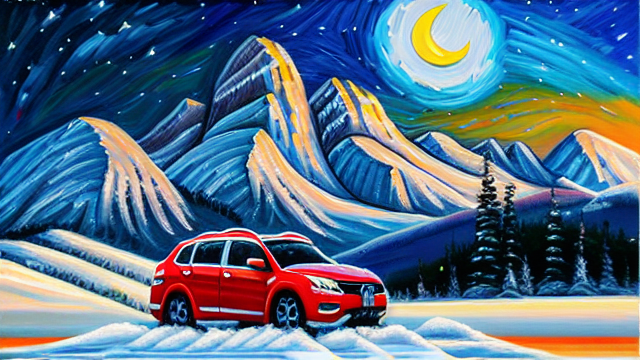

Image saved.


""

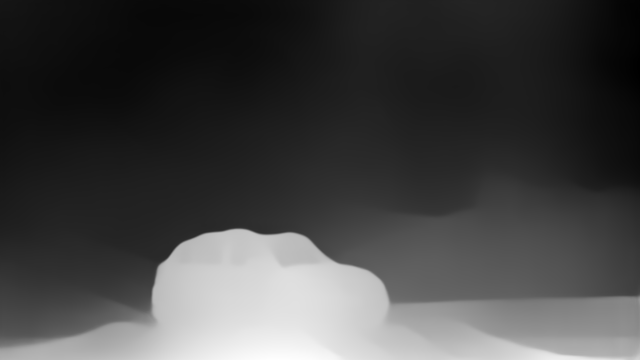

Depth acquired.
CGH starts.


Gradient Descent, loss:1088.8364


""

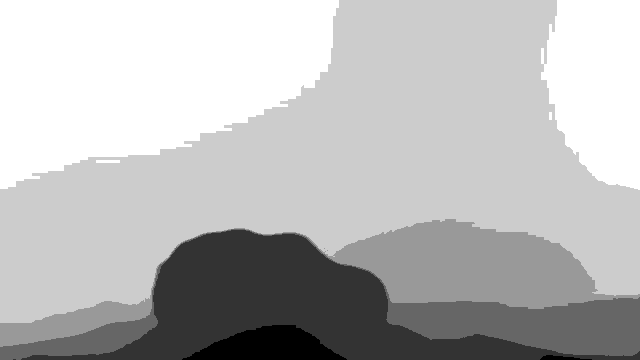

""

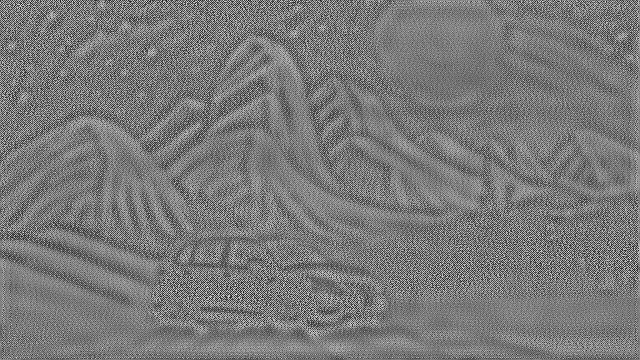

,,,,,

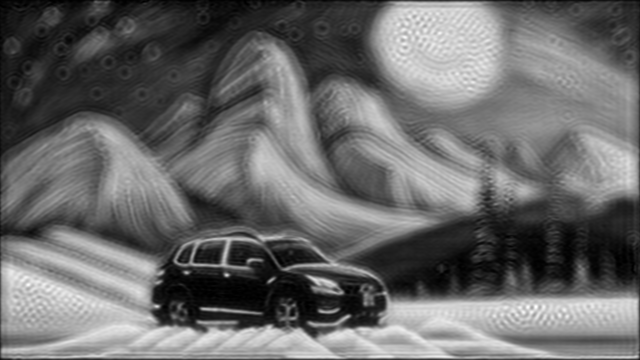
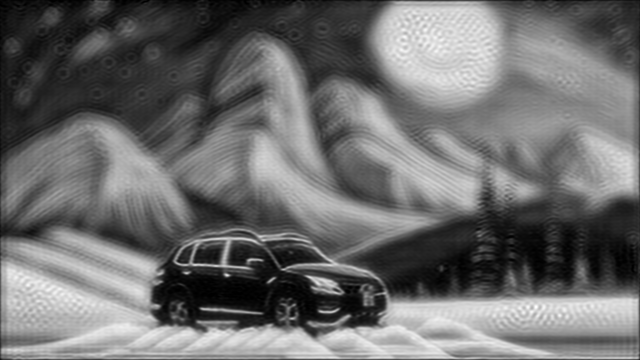
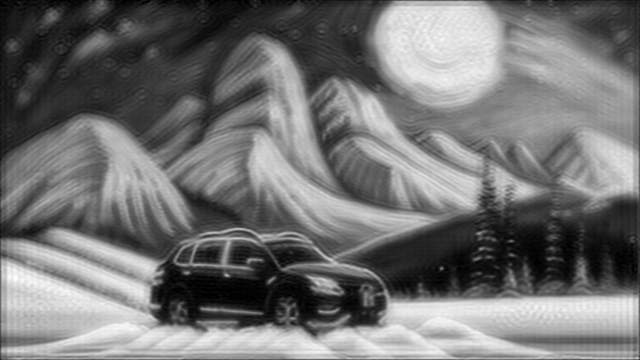
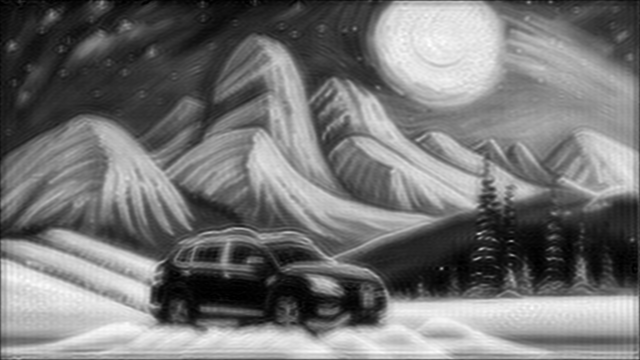
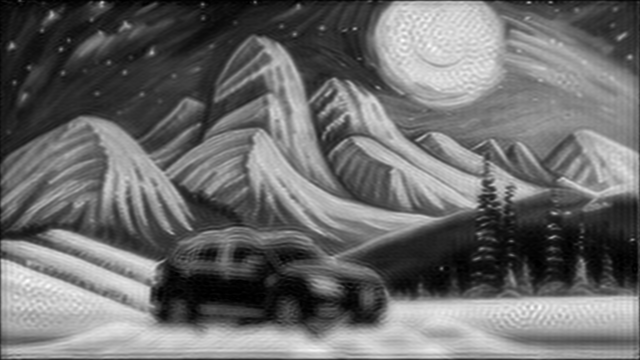
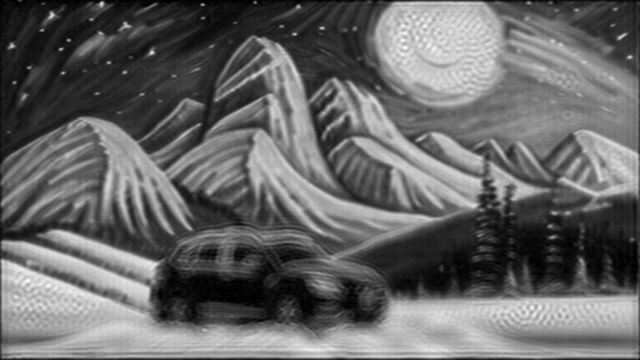

Outputs stored at /content/output/


In [5]:
#@title #Pipeline
prompt = "In oil painting style, a car is on the snow-capped mountains under the starry moon." #@param {type:"string"}
inference_steps = 64 #@param
num_images = 1
output_dir = "/content/" #@param {type:"string"}
safety_check = False #@param {type:"boolean"}
disp_images = True #@param {type:"boolean"}
\
img_height = 360 # [2400, 4094]
img_width = 640
image_length = 768
seed = random.randint(0, 2147483647)

if safety_check:
  negative_prompt = "nude, naked"
else:
  negative_prompt = None
  pipe.safety_checker = None

print("Creating images.")
images = pipe(
    prompt,
    height = img_height,
    width = img_width,
    num_inference_steps = inference_steps,
    guidance_scale = 9,
    num_images_per_prompt = num_images,
    negative_prompt = negative_prompt,
    generator = torch.Generator("cuda").manual_seed(seed)
    ).images
if disp_images:
  media.show_images(images)
# display(f"Seed: {seed}")
images[0].save("output0.jpg")
print("Image saved.")

image_or_dir = "/content/output0.jpg"

auto_adjust = True
skip_existing = False

inputs = [image_or_dir]
os.environ['LC_ALL'] = 'C.UTF-8'
os.environ['LANG'] = 'C.UTF-8'
# imgs = list_images(input)
# inputs = []
# for img in imgs:
#   if '_depthmap.png' not in img:
#     inputs.append(img)
# print(inputs)
for i, input in enumerate(inputs):
  dm_tmp = dir_tmp+basename(input)+'_depthmap'+path_ext(input)
  dm_file = output_dir+basename(input)+'_depthmap'+path_ext(input)
  disp_dm_file = dm_file.replace(drive_root, '')
  if os.path.isfile(dm_file) and skip_existing is True:
    op(c.warn, 'File already exists, skipping', disp_dm_file)
  else:
    # print(input)
    img = cv2.imread(input)
    # print(img.size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_batch = transform(img).to(device)
    with torch.no_grad():
      prediction = midas(input_batch)
      prediction = torch.nn.functional.interpolate(
          prediction.unsqueeze(1),
          size=img.shape[:2],
          mode="bicubic",
          align_corners=False,
      ).squeeze()

    output_depth = prediction.cpu().numpy()
    if auto_adjust is True:
      output_depth = ((output_depth - output_depth.min()) / (output_depth.max()-output_depth.min())) * 255
      output_depth = output_depth.astype(np.uint8)

    im = Image.fromarray(output_depth)
    if disp_images:
      media.show_image(im)
    im.convert('RGB').save(dm_tmp)

print("Depth acquired.")

__title__ = 'Realistic Defocus Blur for Multiplane Holography'

print("CGH starts.")
colabSettings = {
    "general": {
        "device": "cuda",
        "iterations": 60,
        "propagation type": "Bandlimited Angular Spectrum",
        "output directory": "/content/output/",
        "learning rate": 0.04,
        "hologram number": 1
    },
    "target": {
        "image filename": "/content/output0.jpg",
        "depth filename": "/content/tmp/output0_depthmap.jpg",
        "scheme": "defocus",
        "color channel": 1,
        "defocus blur size": 20,
        "blur ratio": 3,
        "number of planes": 6,
        "mask limits": [0.0, 1.0, 0.0, 1.0],
        "multiplier": 1.0,
        "weights": [1.0, 1.0, 1.0, 0.0]
    },
    "image": {
        "location": 0.0,
        "delta": 0.001,
        "zero mode distance": 0.3
    },
    "slm": {
        "model": "Jasper Display Educational 4k",
        "pixel pitch": 0.000008,
        "resolution": [img_height, img_width]
    },
    "beam": {
        "wavelength": 0.000000515
    }
}

cgh(colabSettings)
